In [1]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, LeavePOut
from sklearn.model_selection import RepeatedKFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import settings
import warnings
warnings.filterwarnings('ignore')

In [2]:
comorbidity_data_path = f'{settings.output_folder}icd_10_scaled.csv'
dietary_data_path = f'{settings.output_folder}diet.csv'
development_data_path = f'{settings.raw_data_folder}control/country_development_data.csv'
targets_path = f'{settings.raw_data_folder}control/regression_targets.csv'
features_food_path = f'{settings.features_folder}selected_features_rfe_shap_food.csv'
features_comorbidity_path = f'{settings.features_folder}selected_features_rfe_shap_comorbidity.csv'
features_development_path = f'{settings.features_folder}selected_features_rfe_shap_development.csv'
feature_all_path = f'{settings.features_folder}selected_features_rfe_shap_all.csv'

In [3]:
food_data = pd.read_csv(dietary_data_path)
food_data = food_data[food_data.columns[2:]].drop(['Confirmed', 'Deaths', 'Recovered'],axis=1)
food_data.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetal Products,Vegetable Oils,Vegetables,Country
0,0.000030,0.326636,0.223147,0.0,0.733914,0.132792,0.000638,0.148116,0.133538,0.025586,...,0.090683,0.008648,0.101278,0.0,0.093136,0.113588,0.663569,0.246708,0.320304,Afghanistan
1,0.095202,0.741183,0.154200,0.0,0.146948,0.460113,0.022935,0.274058,0.283455,0.039222,...,0.000402,0.036580,0.119830,0.0,0.145522,0.221400,0.226743,0.149209,0.592018,Albania
2,0.011670,0.274016,0.034457,0.0,0.378697,0.313765,0.024193,0.237088,0.103129,0.076753,...,0.080131,0.086139,0.109900,0.0,0.176586,0.160859,0.745976,0.556105,0.585138,Algeria
3,0.251279,0.199301,0.053595,0.0,0.288345,0.022781,0.184776,0.189200,0.290182,0.051748,...,0.001731,0.534029,0.030582,0.0,0.130798,0.004750,0.764589,0.390946,0.078466,Angola
4,0.226478,0.656624,0.171604,0.0,0.131001,0.118321,0.346861,0.356505,0.621373,0.217600,...,0.216778,0.023982,0.225526,0.0,0.318216,0.043980,0.311472,0.346539,0.249017,Antigua and Barbuda


In [4]:
targets = pd.read_csv(targets_path)
print(f'Missing values: {targets.isnull().sum()}')
targets.head()

Missing values: Deaths       0
Confirmed    0
Recovered    0
Country      0
dtype: int64


,Deaths,Confirmed,Recovered,Country
0,0.006186,0.142134,0.123374,Afghanistan
1,0.050951,2.967301,1.792636,Albania
2,0.006558,0.244897,0.167572,Algeria
3,0.001461,0.061687,0.056808,Angola
4,0.108227,4.356147,3.905192,Argentina


In [5]:
comorbidity_data = pd.read_csv(comorbidity_data_path)
comorbidity_data = comorbidity_data[comorbidity_data.columns[1:]]
comorbidity_data.head()

,"Endocrine, nutritional and metabolic diseases",Mental and behavioural disorders,Diseases of the nervous system,Diseases of the eye and adnexa and ear and mastoid process,Diseases of the circulatory system,Diseases of the respiratory system,Diseases of the digestive system,Diseases of the skin and subcutaneous tissue,Diseases of the musculoskeletal system and connective tissue,Diseases of the genitourinary system,"Pregnancy, childbirth and the puerperium",Certain conditions originating in the perinatal period,"Congenital malformations, deformations and chromosomal abnormalities","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified",External causes of morbidity and mortality,infectious and parasitic diseases,Neoplasms,Country
0,0.116819,0.003982,0.029111,0.358620,0.317068,0.106863,0.528042,0.099971,0.018798,0.302565,0.212921,0.186310,0.715048,0.498261,0.213145,0.204136,0.056119,Egypt
1,0.007047,0.000175,0.001227,0.004683,0.004962,0.002462,0.002225,0.003033,0.001920,0.007139,0.007311,0.069729,0.046214,0.032297,0.014364,0.005927,0.001819,Libyan Arab Jamahiriya
2,0.020303,0.000613,0.000982,0.000000,0.004010,0.002546,0.004058,0.012974,0.003137,0.002798,0.010916,0.006106,0.009091,0.001477,0.005225,0.003640,0.002076,Mauritius
3,0.000538,0.000065,0.000230,0.014048,0.000221,0.000137,0.000285,0.000948,0.000378,0.000178,0.003025,0.002662,0.004489,0.001181,0.000163,0.000224,0.000217,Mayotte
4,0.025356,0.001458,0.006734,0.037462,0.012426,0.006090,0.013126,0.015431,0.008845,0.019342,0.056512,0.181005,0.071820,0.124645,0.024429,0.018527,0.008840,Morocco


In [6]:
development_data = pd.read_csv(development_data_path)
development_data.head()

,Country,Obesity,Undernourished,Population,Annual Average Temperature,Max Latitude,Min Latitude,Max Longitude,Min Longitude,HDI Rank,...,gdp_2018,gdp_2019,code,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature
0,Afghanistan,0.037471,0.478109,0.027721,0.689775,0.602919,0.723203,0.700916,0.694015,0.893617,...,0.719723,0.876126,0.476531,0.024429,0.476531,0.002857,0.575778,0.710354,0.716581,0.612820
1,Albania,0.454333,0.064799,0.001985,0.671682,0.639673,0.806625,0.547690,0.575061,0.361702,...,0.820069,0.837838,0.713605,0.001962,0.713605,0.005714,0.598310,0.620379,0.659867,0.644493
2,Algeria,0.555035,0.024518,0.031592,0.888663,0.590785,0.638480,0.521881,0.494401,0.478723,...,0.726644,0.806306,0.000000,0.028022,0.000000,0.008571,0.757493,0.872619,0.913515,0.816447
3,Angola,0.091335,0.394046,0.023153,0.856803,0.226062,0.337267,0.556283,0.553128,0.781915,...,0.636678,0.768018,0.002383,0.019921,0.002383,0.017143,0.889659,0.715999,0.634922,0.900425
4,Antigua and Barbuda,0.379391,0.202945,0.000031,0.952521,0.420557,0.622284,0.312344,0.340846,0.409574,...,0.920415,0.864865,0.238265,0.000030,0.238265,0.020000,0.929101,0.842088,0.799537,0.961075


In [7]:
merged = food_data.merge(comorbidity_data, how='inner', on='Country')
merged = merged.merge(development_data, on='Country', how='inner')
merged = merged.merge(targets, on='Country', how='inner')
merged.head()

,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Miscellaneous,...,"Population,Total Population - Both sexes",WHO code,FAO code,Winter Average Temperature,Spring Average Temperature,Summer Average Temperature,Autumn Average Temperature,Deaths,Confirmed,Recovered
0,0.185313,0.713814,0.173578,0.000000,0.161196,0.548327,0.037607,0.152709,0.821974,0.000000,...,0.030064,0.240648,0.022857,0.839132,0.496665,0.362201,0.791878,0.108227,4.356147,3.905192
1,0.023402,0.595196,0.259907,0.000000,0.198544,0.438625,0.031320,0.206262,0.338390,0.079870,...,0.001995,0.714081,0.000000,0.478700,0.540716,0.584616,0.529009,0.105345,5.681225,5.398410
2,0.248082,0.686090,0.260696,0.000655,0.057812,0.255123,0.115781,0.133698,0.643951,0.145771,...,0.016748,0.955444,0.025714,0.960246,0.648240,0.525721,0.934468,0.003530,0.112025,0.101289
3,0.334282,0.700335,0.721411,0.000218,0.079941,0.451243,0.074344,0.132597,0.431510,0.000045,...,0.006017,0.714796,0.028571,0.482139,0.508405,0.497334,0.511132,0.089679,4.739982,4.496870
4,0.149855,0.529113,0.191850,0.000000,0.155133,0.402945,0.301188,0.176358,0.568194,0.790046,...,0.000162,0.245413,0.037143,0.933904,0.841944,0.786833,0.960158,0.006272,0.583972,0.470035


In [8]:
food_data = food_data.merge(targets, on='Country', how='inner')

In [9]:
development_data = development_data.merge(targets, on='Country', how='inner')

In [10]:
comorbidity_data = comorbidity_data.merge(targets, on='Country', how='inner')

In [11]:
label_values = ['Deaths', 'Recovered', 'Confirmed']
features_all =  merged.columns.drop(['Country'])
features_all = features_all.drop(label_values)
features_food = food_data.columns.drop(label_values)
features_comorbidity = comorbidity_data.columns.drop(label_values)
features_development = development_data.columns.drop(label_values)
features_food = features_food.drop(['Country'])
features_comorbidity = features_comorbidity.drop(['Country'])
features_development = features_development.drop(['Country', 'WHO code', 'FAO code'])
features_all = features_all.drop(['WHO code', 'FAO code'])

In [12]:
X_food = food_data[features_food]
Y_food = food_data[label_values]
X_comorbidity = comorbidity_data[features_comorbidity]
Y_comorbidity = comorbidity_data[label_values]
X_development = development_data[features_development]
Y_development = development_data[label_values]
X_all = merged[features_all]
Y_all = merged[label_values]

In [13]:
selected_features_food = pd.read_csv(features_food_path)
selected_features_food = selected_features_food['selected_features']
selected_features_comorbidity = pd.read_csv(features_comorbidity_path)
selected_features_comorbidity = selected_features_comorbidity['selected_features']
selected_features_development = pd.read_csv(features_development_path)
selected_features_development = selected_features_development['selected_features']
selected_features_all = pd.read_csv(feature_all_path)
selected_features_all = selected_features_all['selected_features']

In [14]:
def hyper_parameter_search(X, Y, params):
  xgb = XGBRegressor(n_jobs=-1)
  gscv = GridSearchCV(xgb, params, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
  xgboost_best = gscv.fit(X = X, y=Y)
  return xgboost_best.best_params_, xgboost_best.best_score_

In [15]:
def cross_validation_predictions(regressor, data, target, folds=-1):
  scores = {}
  scores['neg_mean_absolute_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_mean_absolute_error', n_jobs=-1).mean()
  scores['neg_median_absolute_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_median_absolute_error', n_jobs=-1).mean()
  scores['neg_mean_squared_error'] = cross_val_score(regressor, data, target, cv=LeaveOneOut(), scoring='neg_mean_squared_error', n_jobs=-1).mean()
  predictions = cross_val_predict(regressor, data, target, cv=LeaveOneOut(), n_jobs=-1)
  return scores, predictions

In [16]:
PARAMS = {
    'max_depth': [2, 3, 5, 7],
    'min_child_weight': [3, 4, 5, 6, 7],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200, 250]
}

In [17]:
all_params, all_score = hyper_parameter_search(X_all[selected_features_all], Y_all['Deaths'], PARAMS)

In [18]:
print(f'best parameters: {all_params}')
print(f'score: {all_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 250}
score: -0.027693395150709586


In [19]:
xgb_all = XGBRegressor(gamma = all_params['gamma'],
                       learning_rate = all_params['learning_rate'],
                       max_depth = all_params['max_depth'],
                       min_child_weight = all_params['min_child_weight'],
                       n_estimators = all_params['n_estimators'])

In [20]:
scores_all, predictions_all = cross_validation_predictions(xgb_all, X_all[selected_features_all],
                                                             Y_all['Deaths'])

In [21]:
scores_all

{'neg_mean_absolute_error': -0.027010704553689244,
 'neg_median_absolute_error': -0.027010704553689244,
 'neg_mean_squared_error': -0.0011610946246420107}

In [22]:
print(f'r2_score = {r2_score(Y_all["Deaths"], predictions_all)}')
print(f'mse = {mean_squared_error(Y_all["Deaths"], predictions_all)}')
print(f'mae = {mean_absolute_error(Y_all["Deaths"], predictions_all)}')

r2_score = 0.561166952748757
mse = 0.0011610946246420107
mae = 0.027010704553689244


In [23]:
abs_difs_all = np.abs(predictions_all - Y_all['Deaths'].values)

In [24]:
ordered_values = []
for i in range(len(abs_difs_all)):
  node = {}
  node['predicted'] = predictions_all[i]
  node['actual'] = Y_all['Deaths'].values[i]
  node['error'] = abs_difs_all[i]
  node['country'] = merged.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

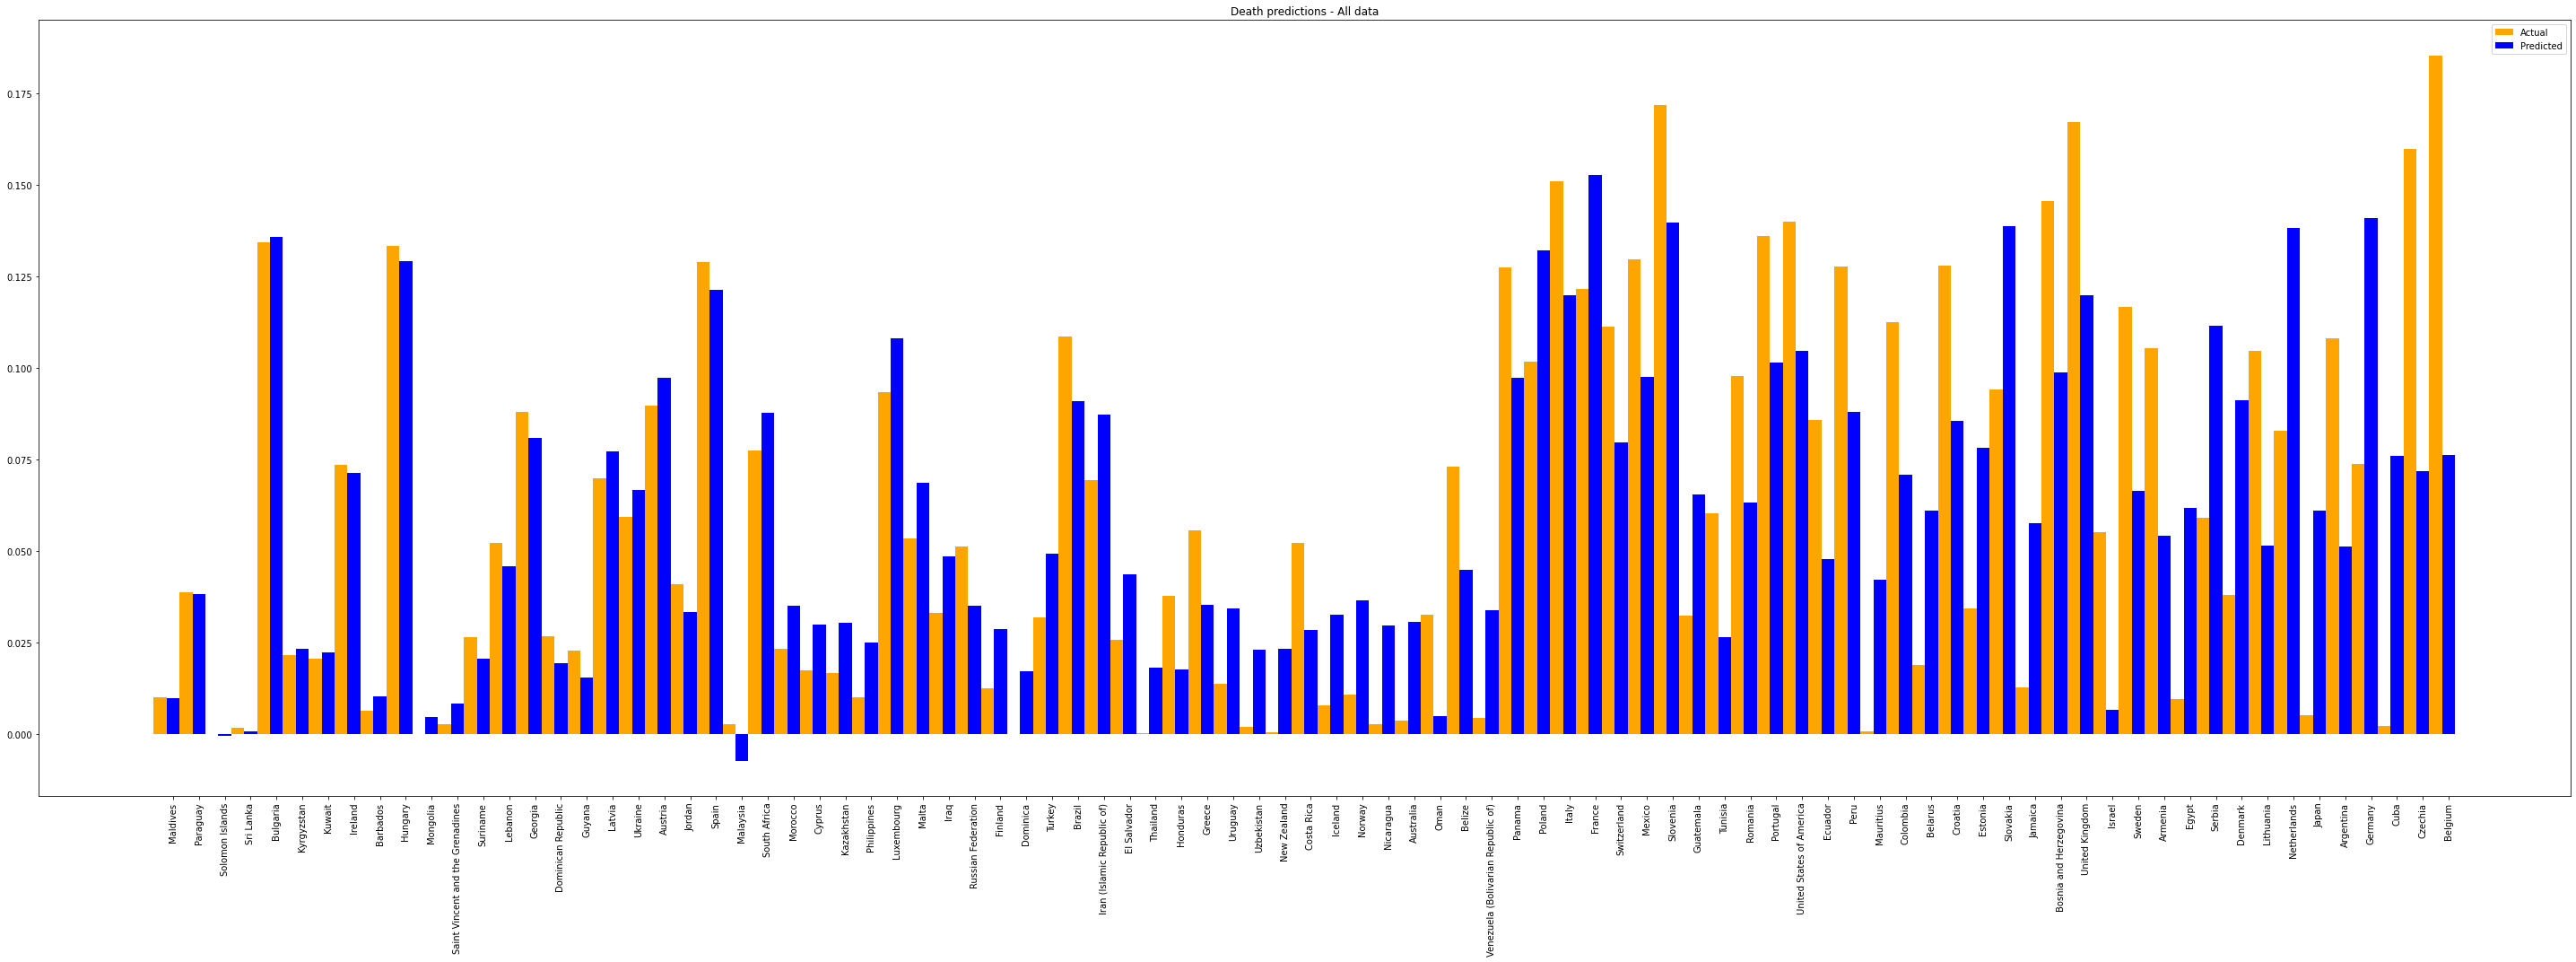

In [25]:
x = np.arange(1, len(X_all) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.legend(['Actual', 'Predicted'])
plt.title('Death predictions - All data')
plt.tight_layout()
plt.savefig('./results/deaths_prediction_distribution_all_data.png')

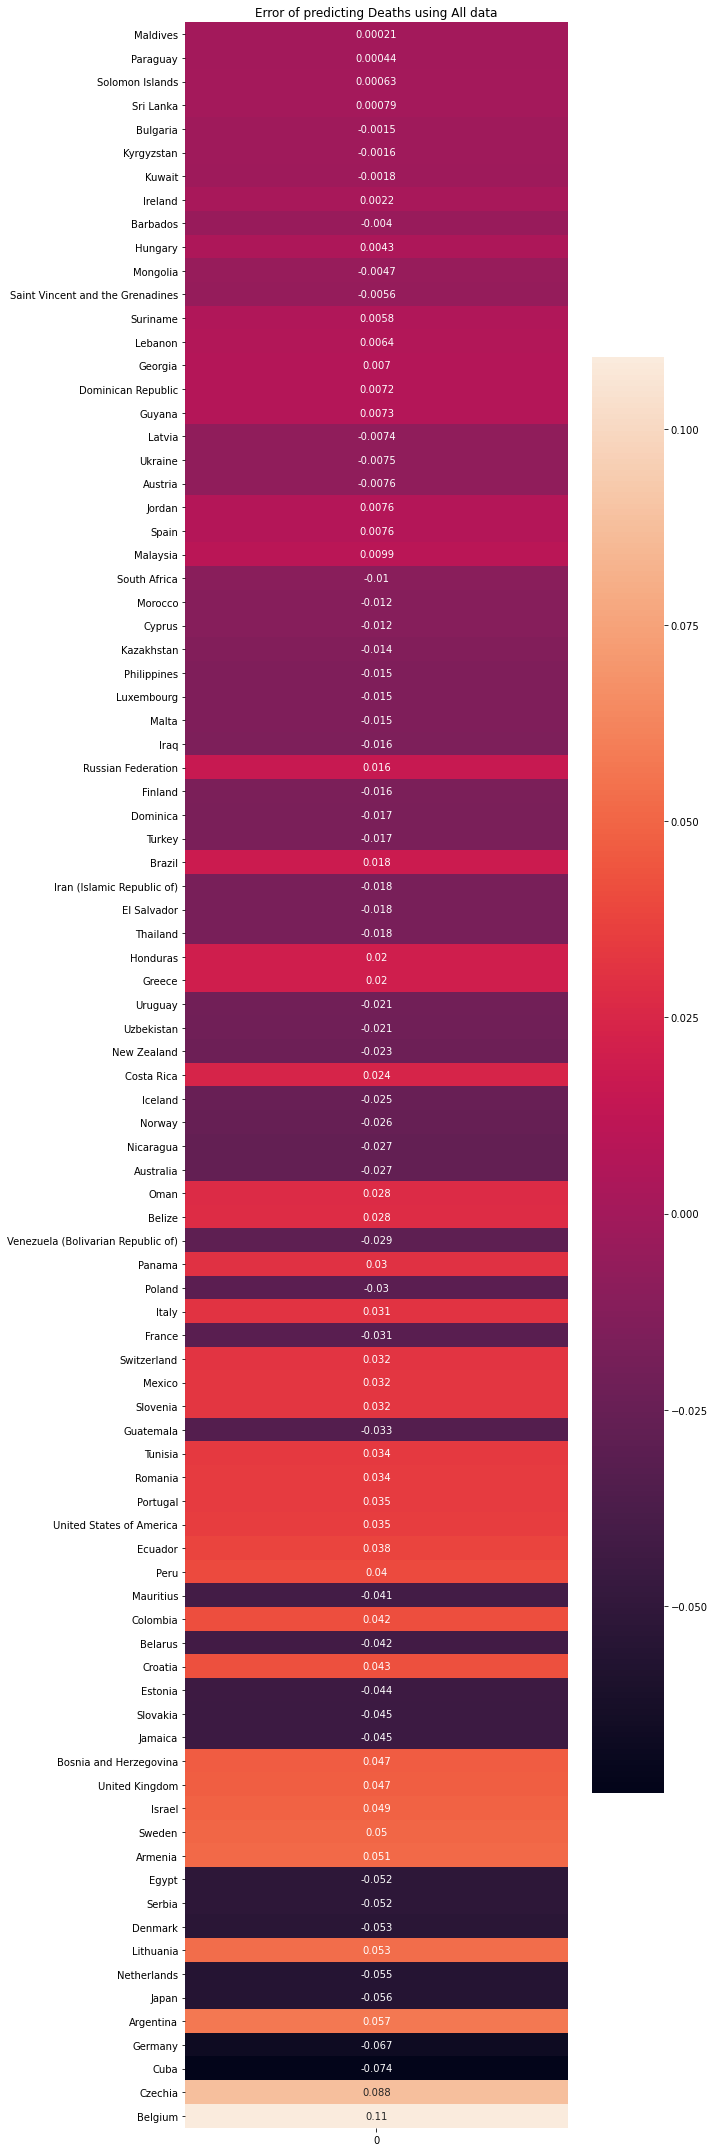

In [26]:
errors_all = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_all = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_all, annot=True, yticklabels=countries_all)
plt.title("Error of predicting Deaths using All data")
plt.tight_layout()
plt.savefig('./results/errors_deaths_all_data.png')

In [27]:
selected_features_food = selected_features_food.tolist()
selected_features_food.append('Country')
selected_features_development = selected_features_development.tolist()
selected_features_development.append('Country')
selected_features_comorbidity = selected_features_comorbidity.tolist()
selected_features_comorbidity.append('Country')

In [28]:
data_combined_features = merged[selected_features_food]
data_combined_features = data_combined_features.merge(merged[selected_features_comorbidity], on='Country', how='inner')
data_combined_features = data_combined_features.merge(merged[selected_features_development], on='Country', how='inner')
data_combined_features

,Milk - Excluding Butter,Alcoholic Beverages,Animal Products,"Fish, Seafood",Eggs,Fruits - Excluding Wine,Animal fats,Country,Neoplasms,Diseases of the musculoskeletal system and connective tissue,Mental and behavioural disorders,Max Latitude,Obesity,Annual Average Temperature
0,0.373834,0.185313,0.713814,0.037607,0.548327,0.152709,0.173578,Argentina,0.090676,0.076196,0.019168,0.073068,0.599532,0.696697
1,0.540608,0.023402,0.595196,0.031320,0.438625,0.206262,0.259907,Armenia,0.014712,0.008761,0.000247,0.627715,0.421546,0.564674
2,0.472108,0.248082,0.686090,0.115781,0.255123,0.133698,0.260696,Australia,0.064172,0.088339,0.067131,0.183417,0.644028,0.848765
3,0.424990,0.334282,0.700335,0.074344,0.451243,0.132597,0.721411,Austria,0.029609,0.024360,0.015780,0.695595,0.444965,0.533885
4,0.239655,0.149855,0.529113,0.301188,0.402945,0.176358,0.191850,Barbados,0.000789,0.001070,0.000358,0.381957,0.512881,0.951112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.493562,0.257429,0.648309,0.099699,0.366767,0.160419,0.228878,United Kingdom,0.234246,0.286198,0.346003,0.799701,0.622951,0.569972
85,0.494547,0.243636,0.621131,0.092447,0.453931,0.145926,0.169913,United States of America,0.850558,0.865323,1.000000,0.892377,0.805621,0.573641
86,0.507157,0.164473,0.598510,0.055630,0.427819,0.136961,0.174737,Uruguay,0.011801,0.020377,0.007026,0.000000,0.608899,0.754617
87,0.608265,0.058676,0.535520,0.011458,0.262757,0.179586,0.114247,Uzbekistan,0.018036,0.012711,0.000258,0.625341,0.290398,0.662754


In [29]:
PARAMS = {
    'max_depth': [2, 3, 5],
    'min_child_weight': [3, 4, 5, 6, 7],
    'learning_rate': [0.003, 0.05, 0.1, 0.25, 0.5],
    'gamma': [0, 0.1, 0.3],
    'n_estimators': [35, 50, 100, 150, 200]
}

In [30]:
combined_params, combined_score = hyper_parameter_search(data_combined_features[data_combined_features.columns.drop(['Country'])], 
                                                         Y_all['Deaths'], PARAMS)

In [31]:
print(f'best parameters: {combined_params}')
print(f'score: {combined_score}')

best parameters: {'gamma': 0, 'learning_rate': 0.25, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100}
score: -0.030571334424273726


In [32]:
xgb_combined = XGBRegressor(gamma = combined_params['gamma'], 
                            learning_rate = combined_params['learning_rate'],
                            max_depth = combined_params['max_depth'], 
                            min_child_weight = combined_params['min_child_weight'],
                            n_estimators = combined_params['n_estimators'])

In [33]:
scores_combined, predictions_combined = cross_validation_predictions(xgb_combined,
                                                                     data_combined_features[data_combined_features.columns.drop(['Country'])],
                                                             Y_all['Deaths'])

In [34]:
scores_combined

{'neg_mean_absolute_error': -0.03237458082663424,
 'neg_median_absolute_error': -0.03237458082663424,
 'neg_mean_squared_error': -0.0017916915282244347}

In [35]:
print(f'r2_score = {r2_score(Y_all["Deaths"], predictions_combined)}')
print(f'mse = {mean_squared_error(Y_all["Deaths"], predictions_combined)}')
print(f'mae = {mean_absolute_error(Y_all["Deaths"], predictions_combined)}')

r2_score = 0.32283430103090605
mse = 0.0017916915282244347
mae = 0.03237458082663424


In [36]:
abs_difs_combined = np.abs(predictions_combined - Y_all['Deaths'].values)

In [37]:
ordered_values = []
for i in range(len(abs_difs_combined)):
  node = {}
  node['predicted'] = predictions_combined[i]
  node['actual'] = Y_all['Deaths'].values[i]
  node['error'] = abs_difs_combined[i]
  node['country'] = data_combined_features.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

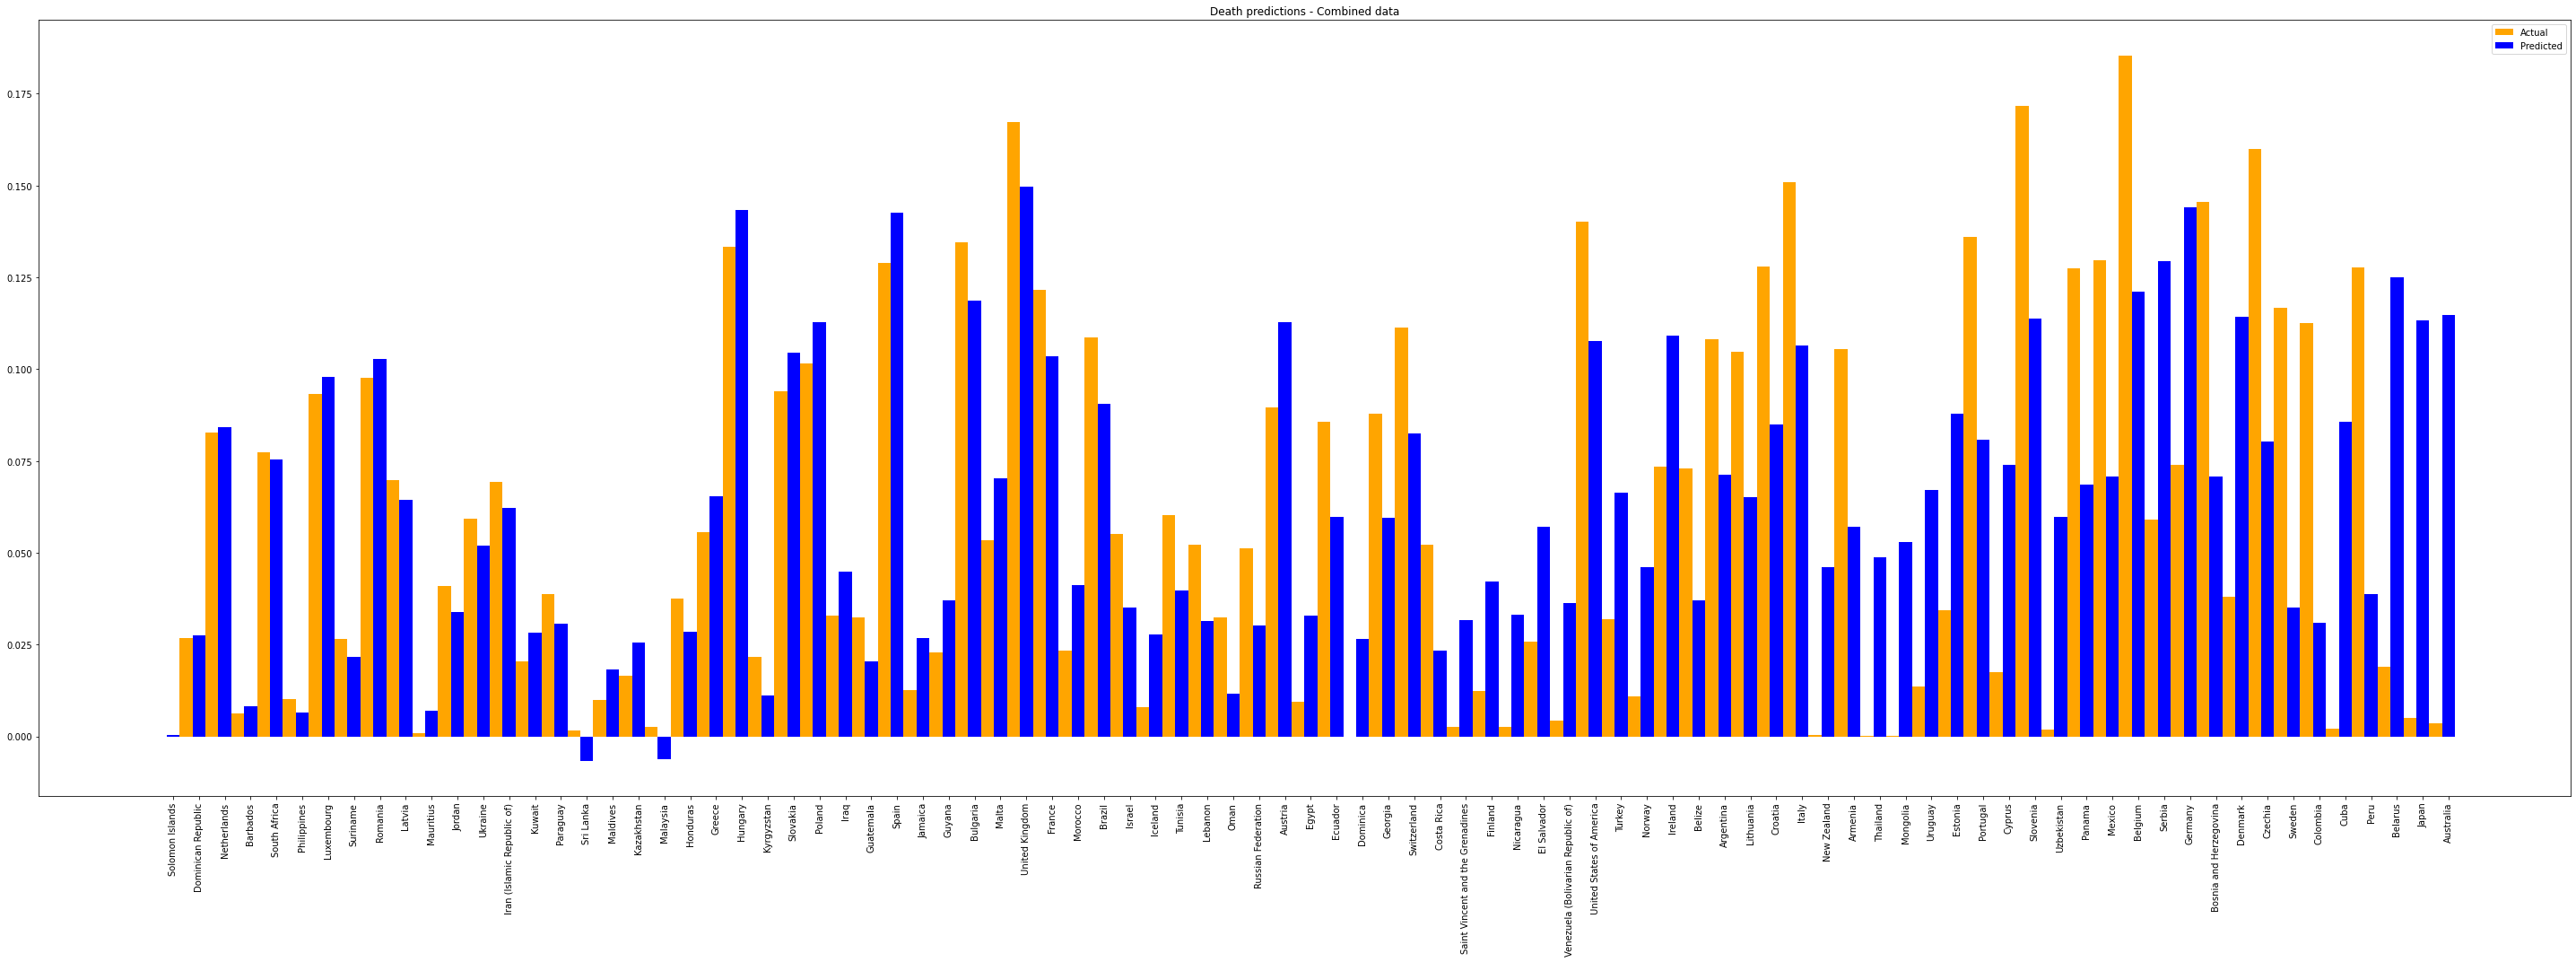

In [38]:
x = np.arange(1, len(X_all) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['actual'], width=0.5, color='orange', align='center', label='True values')
  plt.bar(x[i], elem['predicted'], color='blue', label='Predicted values', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.legend(['Actual', 'Predicted'])
plt.title('Death predictions - Combined data')
plt.tight_layout()
plt.savefig('./results/deaths_prediction_distribution_combined_data.png')

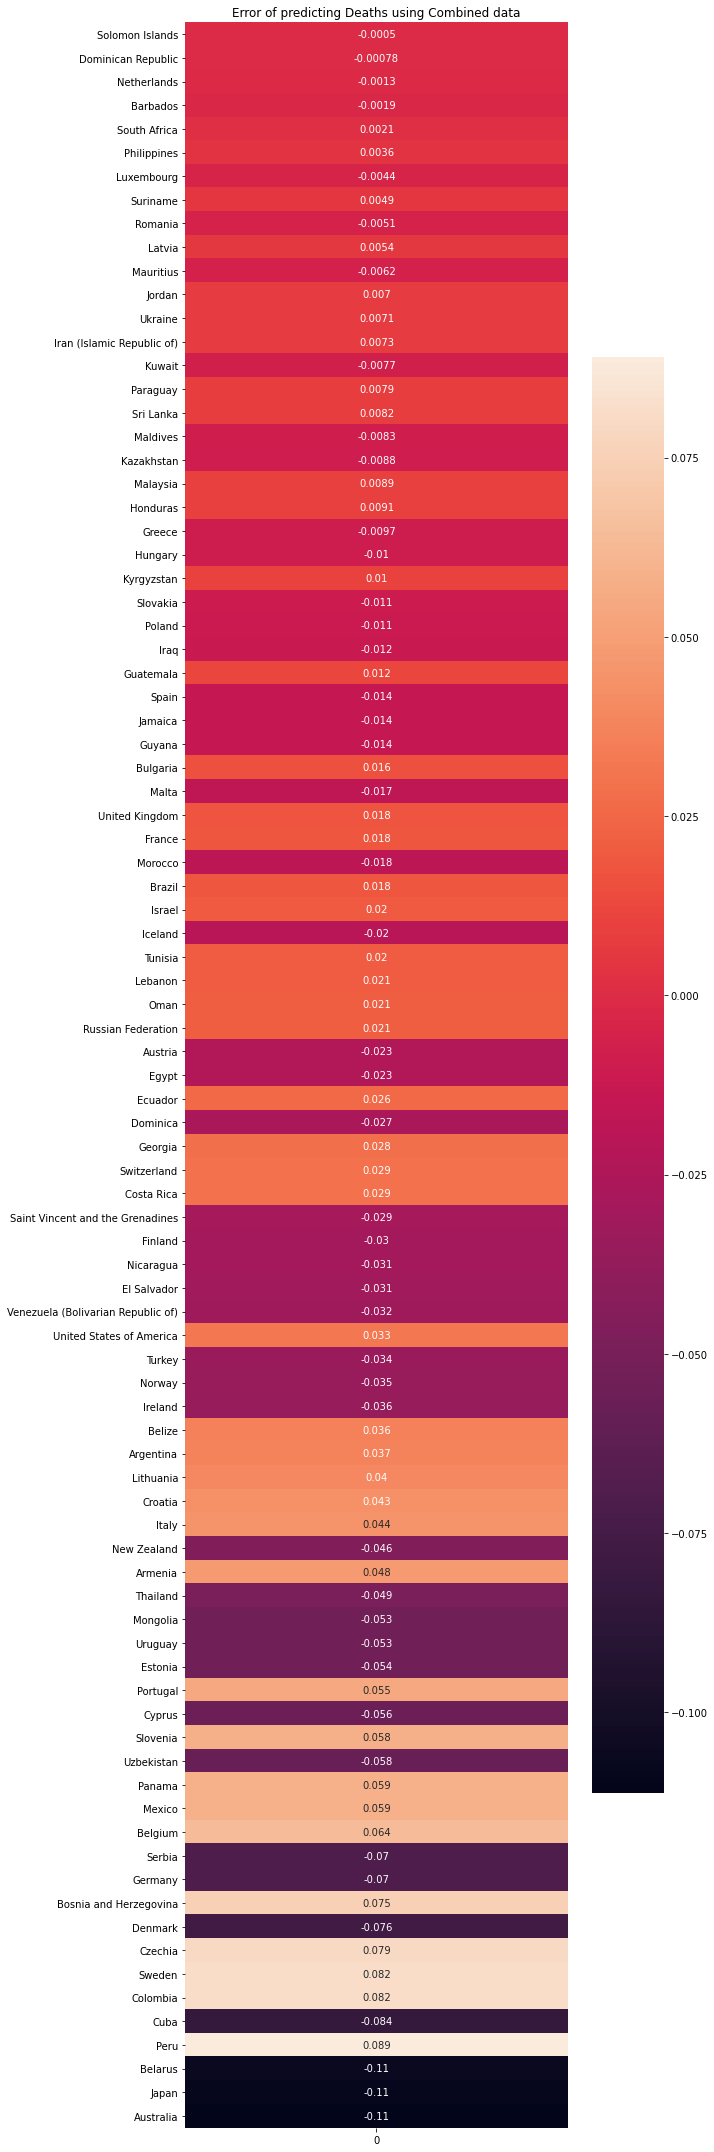

In [39]:
errors_combined = [[val['actual'] - val['predicted']] for val in ordered_values]
countries_combined = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_combined, annot=True, yticklabels=countries_combined)
plt.title("Error of predicting Deaths using Combined data")
plt.tight_layout()
plt.savefig('./results/error_deaths_combined_data.png')

In [40]:
ordered_values = []
for i in range(len(abs_difs_combined)):
  node = {}
  node['predicted combined'] = predictions_combined[i]
  node['predicted all'] = predictions_all[i]
  node['error'] = np.abs(predictions_all[i] - predictions_combined[i])
  node['country'] = data_combined_features.iloc[i].Country
  ordered_values.append(node)

ordered_values.sort(key = lambda item: item['error'])

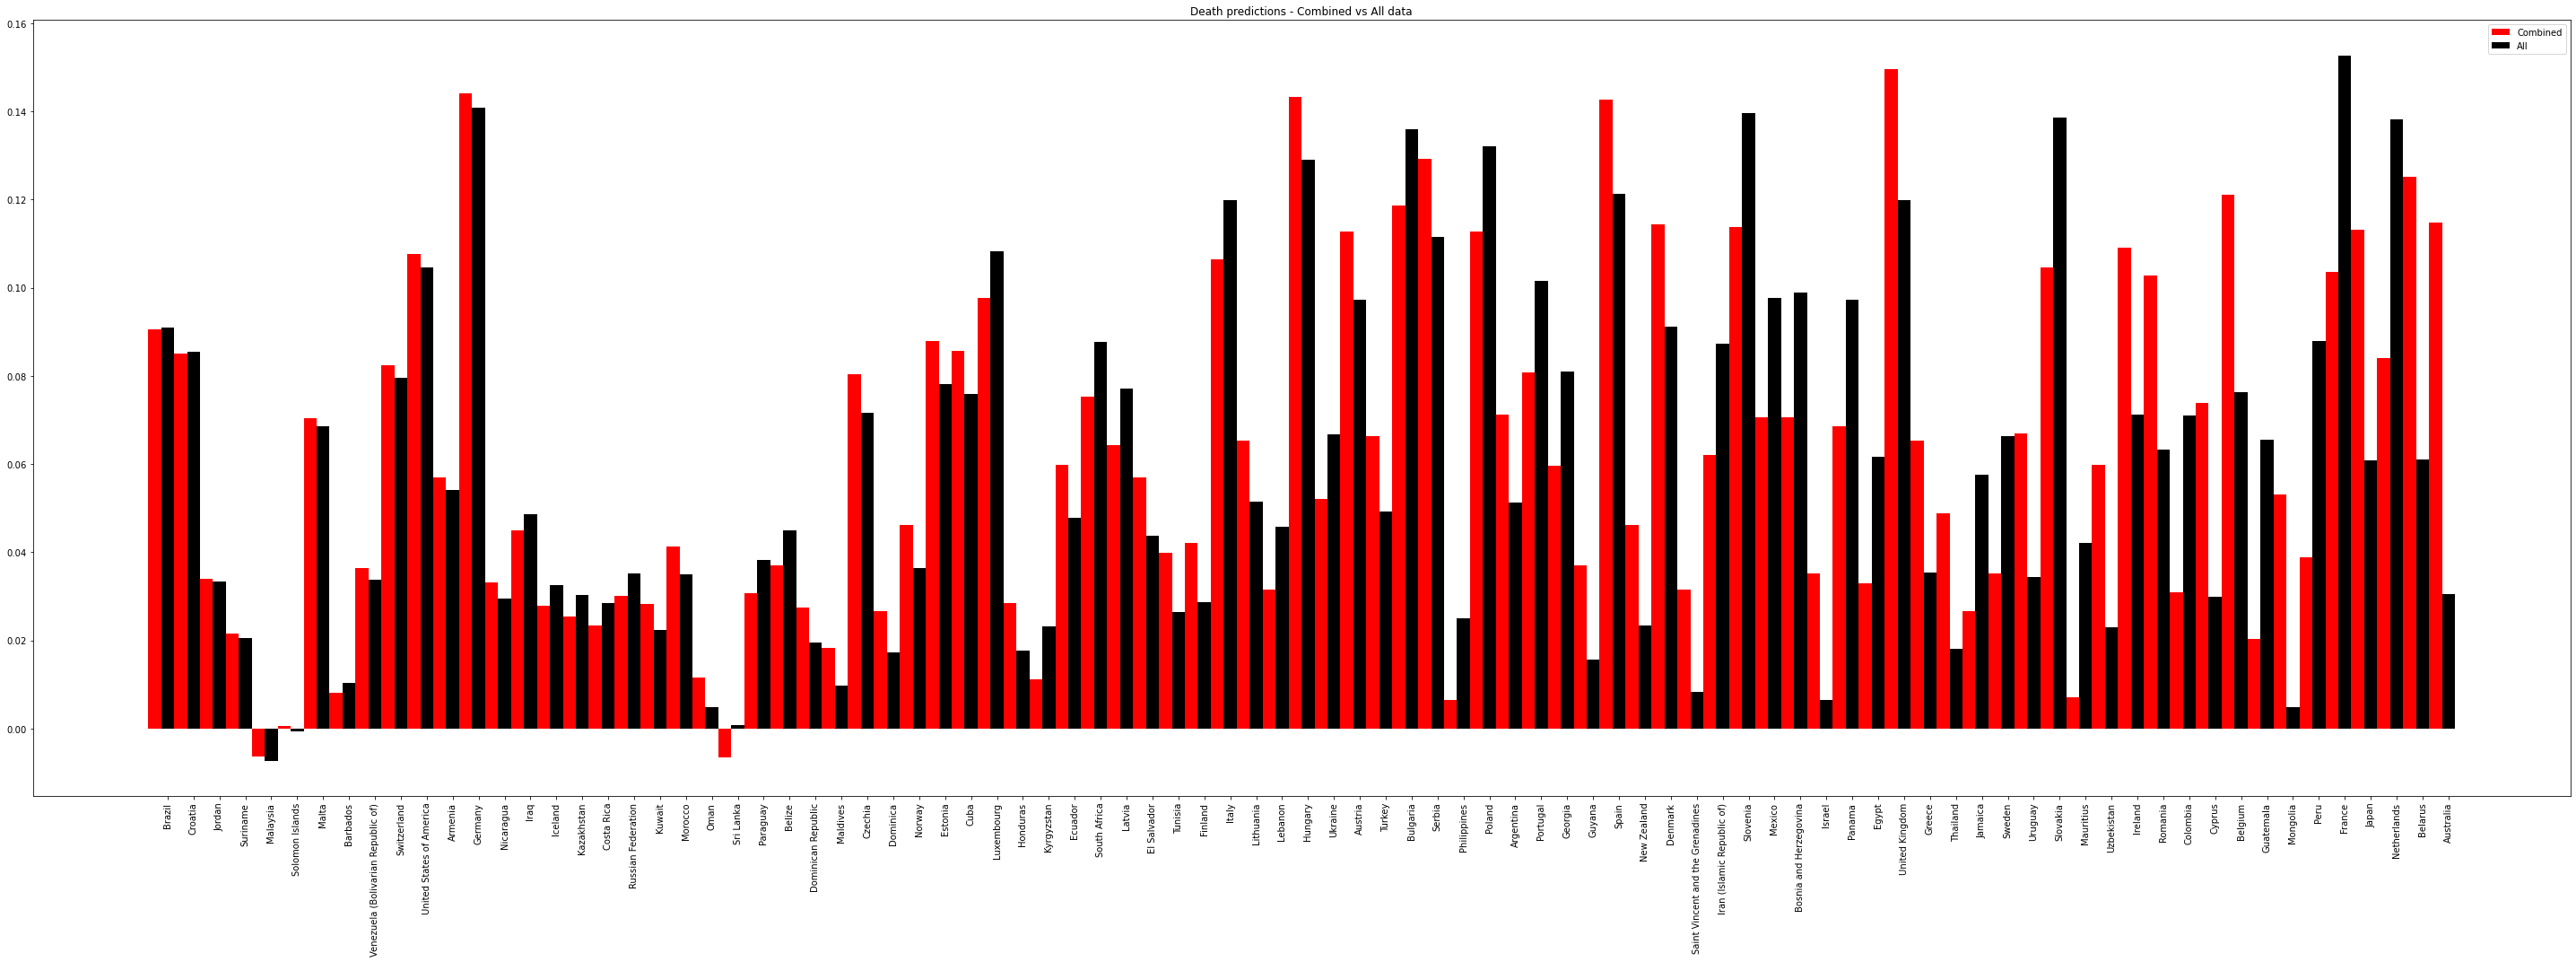

In [41]:
x = np.arange(1, len(X_all) + 1)
plt.figure(figsize=(40, 15))
countries = []
for i, elem in enumerate(ordered_values):
  plt.bar(x[i]-0.5, elem['predicted combined'], width=0.5, color='red', align='center', label='Predicted Combined')
  plt.bar(x[i], elem['predicted all'], color='black', label='Predicted All', width = 0.5, align='center')
  countries.append(elem['country'])
plt.xticks(x, countries, rotation=90)
plt.title('Death predictions - Combined vs All data')
plt.legend(['Combined', 'All'])
plt.tight_layout()
plt.savefig('./results/deaths_predictions_distribution_combined_vs_all_data.png')

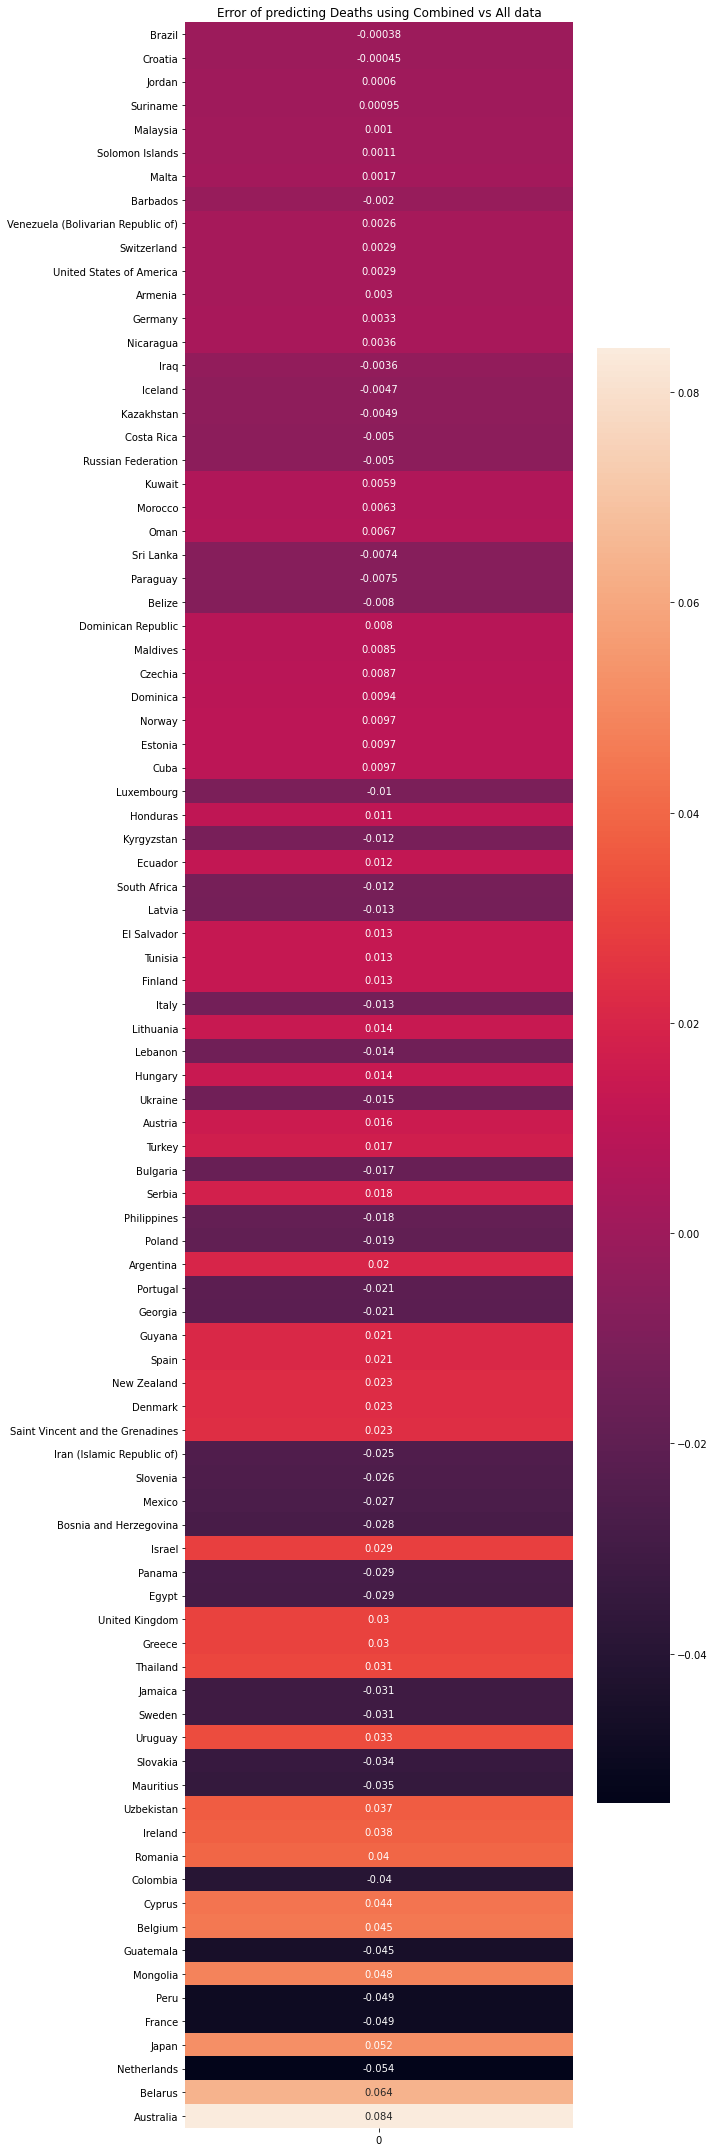

In [42]:
errors_combined = [[val['predicted combined'] - val['predicted all']] for val in ordered_values]
countries_combined = [val['country'] for val in ordered_values]

plt.figure(figsize=(10, 30))
sns.heatmap(errors_combined, annot=True, yticklabels=countries_combined)
plt.title("Error of predicting Deaths using Combined vs All data")
plt.tight_layout()
plt.savefig('./results/error_deaths_combined_vs_all_data.png')